### Part 1

In [3]:
!pip install imageio

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 3.4/3.4 MB 1.2 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as imageio
from utils import *

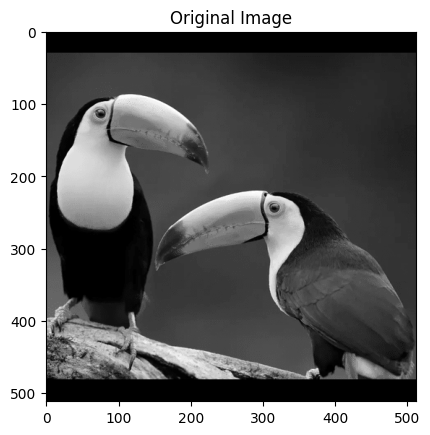

In [5]:
# read and display the original image
clean_img = imageio.imread('pic1.png').astype('float32')
plt.imshow(clean_img, cmap='gray')
plt.title('Original Image');

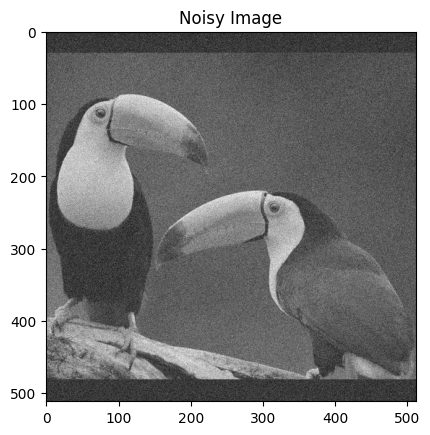

In [6]:
# add a white Gaussian noise with standard deviation of sigma
sigma = 20
noisy_img = clean_img + np.random.normal(scale=sigma, size=clean_img.shape)
plt.figure()
plt.imshow(noisy_img, cmap='gray')
plt.title('Noisy Image');

In [8]:
p = 8    # patch size
N = noisy_img.shape[0]
Y = extract_patches(noisy_img, patch_size=p)
assert Y.shape == (p**2, (N-p+1)**2), 'Invlid patch extraction'

In [54]:
Y.shape
# X = np.zeros((Y.shape[0],Y.shape[1]))
# X[:,2].reshape(64,1)

(64, 255025)

In [115]:
error_mp = []
error_omp = []

In [136]:
# implement MP and OMP sparse coding algorithms
# for each column of the dictionary, stop where norm(residual) ** 2 < D.shape[0] * tol ** 2

def MP(D: np.ndarray, Y: np.ndarray, tol:float) -> np.ndarray:
    A = D.copy()
    X = np.zeros((121,Y.shape[1]))
    
    for i in range(Y.shape[1]):
        
        b = Y[:,i]
        
        k=0
        x=np.zeros((121,1))
        r=b
        S = set()
        stop = False
        while stop == False:
            k=k+1
            E_j=np.zeros(A.shape[1])
            for j in range(A.shape[1]):
                E_j[j]=np.linalg.norm(r)**2 - (np.inner(A[:,j],r) )**2 / np.inner(A[:,j],A[:,j])

            j_0=np.argmax(E_j)
            S.add(j_0)

            x = x
            z_j_0 = np.inner(A[:,j_0],r) /np.inner(A[:,j_0],A[:,j_0])
            x[j_0,0] = x[j_0,0] + z_j_0
            r = r - z_j_0 * A[:,j_0]
            error_mp.append(np.linalg.norm(r)**2)
            if  np.linalg.norm(r)**2 < D.shape[0] * tol ** 2:
                stop=True

        X[:,i] = x.reshape(121)
        
    return X
         
    
    

k=0
# optional
def OMP(D: np.ndarray, Y: np.ndarray, tol:float) -> np.ndarray:
    A = D.copy()
    X = np.zeros((121,Y.shape[1]))
    
    for i in range(Y.shape[1]):
        
            b = Y[:,i]

            k=0
            x=np.zeros((121,1))
            r=b
            S = []
            stop = False
            while stop == False:
                    k=k+1
                    E_j=np.zeros(A.shape[1])
                    for j in range(A.shape[1]):
                        E_j[j]=np.linalg.norm(r)**2 - (np.inner(A[:,j].reshape(64),r.reshape(64)) )**2 / np.inner(A[:,j],A[:,j])

                    j_0=np.argmax(E_j)
                    S.append(j_0)
                    A_s = np.zeros((A.shape[0],len(S)))
                    for s in range(len(S)):
                        A_s[:,s]  = A [:,S[s]]

                    x_s = np.linalg.pinv(A_s.T @ A_s ) @ A_s.T @ b #####invvvvvvvvvvvvvv
                    r = b.reshape(64,1) - A_s @ x_s.reshape(len(S),1)
        #             error_omp.append(np.linalg.norm(r)**2)
                    if  np.linalg.norm(r)**2 < D.shape[0] * tol ** 2 or k==1:
                        stop=True

            for  k in range(len(S)):
                x[S[k]] = x_s[k]

            X[:,i]= x.reshape(121)
#             error_omp.append(np.linalg.norm(r)**2)
    
    return X

    
    

In [137]:
# implement MOD and KSVD dictionary update algorithms
# `DO NOT forget` to `normalize` columns of the dictionary

def MOD(Y:np.ndarray, X:np.ndarray):
    A = Y @ X.T @ np.linalg.pinv(X @ X.T)
    row,col = A.shape
    for i in range(col):
        A[:,i]=A[:,i]/np.linalg.norm(A[:,i])
    
    return A
    



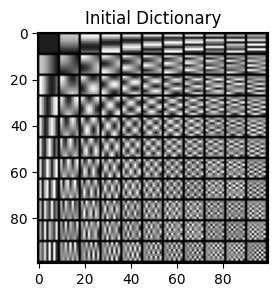

In [138]:
C = 1.075    # noise gain
multiplier = 0.5    # fraction of the noisy image added to the final result

initial_dict = np.load('initial_dictionary.npy') # initialize dictionary to an overcomplete DCT dictionary
    
# visualize the initial dictionary
plt.figure(figsize=(3, 3))
plt.imshow(visualize_dict(initial_dict), cmap='gray');
plt.title('Initial Dictionary');

In [139]:
initial_dict.shape

(64, 121)

### MOD + MP

In [117]:
# training step
final_dict, X = train(Y, initial_dict, num_iter=10, C=1.075, sigma=sigma, sparse_code=MP, dict_update=MOD)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [127]:
# error_mp

In [ ]:
# visualize the final dictionary
plt.figure(figsize=(3, 3))
plt.imshow(visualize_dict(final_dict), cmap='gray');
plt.title('Final Dictionary');

In [ ]:
# reconstruct the image and compare with the noisy and original one
denoised_img = reconstruct_image(initial_dict, X, noisy_img, p, m=0.1)
evaluate(clean_img, noisy_img, denoised_img)

### MOD + OMP

In [140]:
# training step
final_dict, X = train(Y, initial_dict, num_iter=10, C=1.075, sigma=sigma, sparse_code=OMP, dict_update=MOD)

  0%|          | 0/10 [00:00<?, ?it/s]

In [133]:
k

0

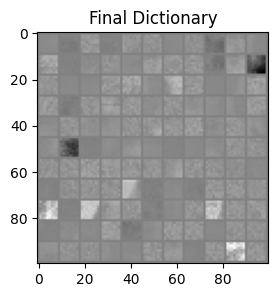

In [141]:
# visualize the final dictionary
plt.figure(figsize=(3, 3))
plt.imshow(visualize_dict(final_dict), cmap='gray');
plt.title('Final Dictionary');

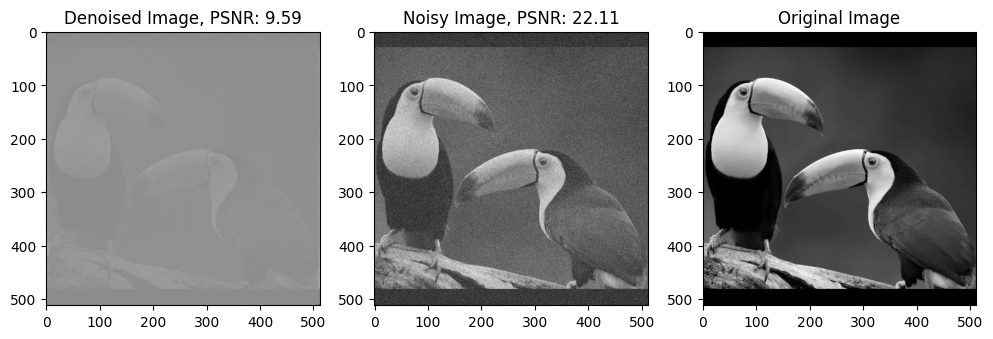

In [142]:
# reconstruct the image and compare with the noisy and original one
denoised_img = reconstruct_image(initial_dict, X, noisy_img, p, m=0.1)
evaluate(clean_img, noisy_img, denoised_img)

## Part 2

* Fit a polynomial of degree $K$ to all columns of the following dataset
to predict number of "Cars" and "Buses" in the years of $2016$,$2017$,$2018$,$2019$ and $2020$.


$$
y_i = \sum_{k=0}^K w_k x_{i}^k + \epsilon_i
$$


Change the value of $K$ from 3 to 5. For each degree, plot the data and your model fit and compare the results.

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt

dataset = pd.read_csv(u'data/arac.csv',sep=';')
dataset

In [ ]:
BaseYear = 1966
K = ...

In [ ]:
x = np.matrix(dataset.Year[0:]).T - BaseYear
cars = np.matrix(dataset.Car[0:]).T
buses = np.matrix(dataset.Bus[0:]).T

In [ ]:
# In this part, change the value of K and show the results for "Cars"
# You may add new cells to show the results separately

# Create Vandermonde Matrix
A = np.hstack(np.power(x, i) for i in range(K + 1))

# Find the W matrix
# You may use linalg.lstsq here
...
f = ...


# Prediction
TargetYears = np.matrix([2016, 2017, 2018, 2019, 2020]).T
A2 = np.hstack(np.power(TargetYears - BaseYear, i) for i in range(K + 1))
# Predict the number of cars for target years
f2 = ...


# Plot the results
plt.plot(x + BaseYear, cars, 'o-')
plt.plot(x + BaseYear, f, 'r')
plt.plot(TargetYears, f2, 'ro-')

print("Predicted Numbers for cars")
print(f2)

In [ ]:
# In this part, change the value of K and show the results for "Buses"
# You may add new cells to show the results separately

# Create Vandermonde Matrix
A = np.hstack(np.power(x, i) for i in range(K + 1))

# Find the W matrix
# You may use linalg.lstsq here
...
f = ...


# Prediction
TargetYears = np.matrix([2016, 2017, 2018, 2019, 2020]).T
A2 = np.hstack(np.power(TargetYears, i) for i in range(K + 1))
# Predict the number of cars for target years
f2 = ...


# Plot the results
plt.plot(x + BaseYear, buses, 'o-')
plt.plot(x + BaseYear, f, 'r')
plt.plot(TargetYears, f2, 'ro-')

print("Predicted Numbers for buses")
print(f2)